In [30]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from statsmodels.stats.multitest import multipletests

# Define experiments

In [31]:
experiments = {"rpl22_oe": [
    ['LNCaP_GFP_1',
     'LNCaP_GFP_2',
     'LNCaP_GFP_3'],
    ['LNCaP_RPL22_1',
     'LNCaP_RPL22_2',
     'LNCaP_RPL22_3']
],
    "rpl22l1_oe": [
    ['CAL851_GFP_1',
     'CAL851_GFP_2',
     'CAL851_GFP_3'],
    ['CAL851_RPL22L1_1',
     'CAL851_RPL22L1_2',
     'CAL851_RPL22L1_3']
],
    "sh704": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh704_1',
     'LNCaP_sh704_2',
     'LNCaP_sh704_3']
],
    "sh705": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh705_1',
     'LNCaP_sh705_2',
     'LNCaP_sh705_3']
]
}

experiment_ids = ["rpl22_oe","rpl22l1_oe","sh704","sh705"]

# Load TPMS and sleuth results

In [32]:
rpl22_oe_sleuth = pd.read_csv("../data/processed/kallisto_sleuth_merge/rpl22_oe.txt", sep="\t", index_col=0)
rpl22l1_oe_sleuth = pd.read_csv("../data/processed/kallisto_sleuth_merge/rpl22l1_oe.txt", sep="\t", index_col=0)
sh704_sleuth = pd.read_csv("../data/processed/kallisto_sleuth_merge/sh704.txt", sep="\t", index_col=0)
sh705_sleuth = pd.read_csv("../data/processed/kallisto_sleuth_merge/sh705.txt", sep="\t", index_col=0)

# Differential expression

In [33]:
def as_si(x, ndp):
    """
    Convert a number to scientific notation

    Parameters
    ----------
    x : float
        number to convert
    ndp: float
        number of decimal places

    Returns
    -------
    x_si : string
        x formatted in scientific notation
    """

    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    x_si = r'{m:s} × $10^{{{e:d}}}$'.format(m=m, e=int(e))

    return x_si

In [36]:
control_color = "grey"
treatment_color = "red"
alpha = 0.5


def plot_tpm_dist(transcript_id, experiment_id, diff_results, ax=None, pal=None, xlabel=None, ylabel=None):

    if ax is None:
        ax = plt.subplot(111)

    if pal is None:
        pal = sns.color_palette([control_color, treatment_color])

    if xlabel is None:
        xlabel = experiment_id

    if ylabel is None:
        ylabel = "mRNA expression, log2(TPM + 1)"

    select_abundance = diff_results.loc[transcript_id]

    controls = experiments[experiment_id][0]
    treatments = experiments[experiment_id][1]

    tpms = np.log2(select_abundance[controls+treatments].astype(np.float64)+1)

    expression_df = pd.DataFrame(index=controls+treatments)

    expression_df["tpm"] = tpms
    expression_df["treatment"] = ["control"] * \
        len(controls)+["treatment"]*len(treatments)

    sns.swarmplot(x="treatment",
                  y="tpm",
                  data=expression_df,
                  ax=ax,
                  palette=pal,
                  s=6,
                  alpha=1,
                  edgecolor="black",
                  )

    sns.barplot(x="treatment",
                y="tpm",
                data=expression_df,
                ax=ax,
                palette=pal,
                alpha=alpha/2,
                linewidth=1,
                ci=None
                )

    means = expression_df.groupby("treatment")["tpm"].mean()

    ax.axhline(means["control"], 0.1, 0.4,
               linewidth=1, color="black", zorder=100)
    ax.axhline(means["treatment"], 0.6, 0.9,
               linewidth=1, color="black", zorder=100)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))

    plt.ylim(0)

    y_max = max(tpms)

    if not np.isnan(select_abundance["qval"]):

        qval = as_si(select_abundance["qval"], 0)
        ax.text(0.5, y_max*1.2, qval, ha="center", fontsize=8)

    return ax, y_max


def plot_tpm_dist_all(transcript_id):

    f, axes = plt.subplots(1, 4, sharey=True, figsize=(4, 3))

    maxes = []

    ax = axes[0]
    ax, y_max = plot_tpm_dist(transcript_id, "rpl22_oe", rpl22_oe_sleuth, ax=ax)
    maxes.append(y_max)
    ax.set_xlabel("RPL22++")

    ax = axes[1]
    ax, y_max = plot_tpm_dist(
        transcript_id, "rpl22l1_oe", rpl22l1_oe_sleuth, ax=ax, ylabel="")
    maxes.append(y_max)
    ax.spines["left"].set_visible(False)
    ax.tick_params(axis='y', which='both', right=False,
                   left=False, labelleft=False)
    ax.set_xlabel("RPL22L1++")

    ax = axes[2]
    ax, y_max = plot_tpm_dist(transcript_id, "sh704",
                              sh704_sleuth, ax=ax, ylabel="")
    maxes.append(y_max)
    ax.spines["left"].set_visible(False)
    ax.tick_params(axis='y', which='both', right=False,
                   left=False, labelleft=False)

    ax = axes[3]
    ax, y_max = plot_tpm_dist(transcript_id, "sh705",
                              sh705_sleuth, ax=ax, ylabel="")
    maxes.append(y_max)
    ax.spines["left"].set_visible(False)
    ax.tick_params(axis='y', which='both', right=False,
                   left=False, labelleft=False)

    plt.ylim(-0.1, max(maxes)*1.25)

    plt.subplots_adjust(wspace=0.4)

    legend_elements = [Line2D([0], [0], marker='o', color="white", label='Control',
                              markerfacecolor=control_color, markersize=8, alpha=alpha),
                       Line2D([0], [0], marker='o', color="white", label='Treatment',
                              markerfacecolor=treatment_color, markersize=8, alpha=alpha)]

    plt.legend(handles=legend_elements,
               loc='upper left', bbox_to_anchor=(1, 1))

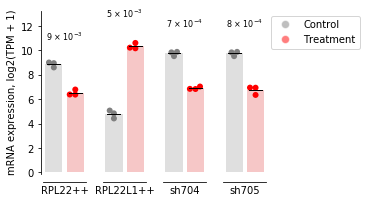

In [37]:
plot_tpm_dist_all("ENST00000463836")

## Volcano plots

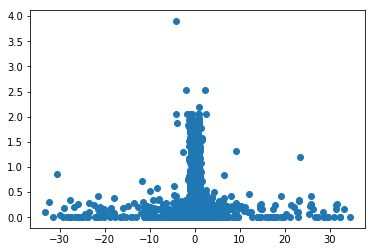

In [66]:
plt.scatter(-np.log2(rpl22_oe_sleuth["median_foldchange"]),-np.log10(rpl22_oe_sleuth["qval"]))

In [77]:
sh704_sleuth

,target_id,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,format_transcript_id,LNCaP_shLuc_1,LNCaP_shLuc_2,LNCaP_shLuc_3,LNCaP_sh704_1,LNCaP_sh704_2,LNCaP_sh704_3,gene_name
ENST00000293894,1,2.921498e-09,0.000185,35.235496,9.358422,1.0,6.460620,1.871684,0.003790,1.867895,0.017286,1.867895,SOX8_ENST00000293894,4.654160,4.437860,4.401460,52.171500,54.138400,47.652600,SOX8
ENST00000244741,2,1.070879e-08,0.000227,32.708139,3.264805,1.0,8.776002,0.652961,0.000286,0.652675,0.015039,0.652675,CDKN1A_ENST00000244741,108.382000,112.225000,113.388000,459.529000,457.977000,434.989000,CDKN1A
ENST00000356644,3,8.261368e-09,0.000227,33.212595,3.072710,1.0,7.584130,0.614542,0.001285,0.613257,0.014398,0.613257,SESN1_ENST00000356644,40.848600,44.705600,41.207500,155.258000,167.182000,162.029000,SESN1
ENST00000290551,4,7.255649e-08,0.000558,28.995237,1.566846,1.0,7.256381,0.313369,0.000764,0.312605,0.014868,0.312605,BTG2_ENST00000290551,29.510300,27.687200,25.258100,70.876500,70.850500,68.501000,BTG2
ENST00000248150,5,7.915357e-08,0.000558,28.826671,9.834109,1.0,4.814527,1.966822,0.017915,1.948907,0.031058,1.948907,GNG13_ENST00000248150,2.992130,2.651740,2.592370,34.110100,32.351800,33.108400,GNG13
ENST00000295830,6,5.842290e-08,0.000558,29.415026,4.804836,1.0,6.133086,0.960967,0.003825,0.957142,0.018781,0.957142,RPL22L1_ENST00000295830,56.322100,61.150300,61.898700,9.907300,9.316120,8.305570,RPL22L1
ENST00000312584,7,4.591716e-08,0.000558,29.881933,1.420542,1.0,7.541076,0.284108,0.000606,0.283503,0.014443,0.283503,TNFRSF10D_ENST00000312584,31.792700,31.313200,28.958900,71.209500,76.460300,76.259400,TNFRSF10D
ENST00000253063,8,7.887279e-08,0.000558,28.833554,3.021911,1.0,6.724447,0.604382,0.001601,0.602781,0.016267,0.602781,SESN2_ENST00000253063,9.803730,8.998710,8.107790,35.774300,35.669300,31.632500,SESN2
ENST00000424922,9,4.714194e-08,0.000558,29.830895,84.380105,1.0,3.056742,16.876021,0.036135,16.839886,0.210771,16.839886,CALD1_ENST00000424922,45.243000,41.107300,42.236200,0.000000,0.000000,0.000000,CALD1
ENST00000529911,10,2.403298e-07,0.000692,26.678102,1.806110,1.0,6.928928,0.361222,0.002595,0.358627,0.015631,0.358627,unnamed_ENST00000529911,30.129200,27.370100,29.373900,79.758800,79.401900,80.434900,NaN


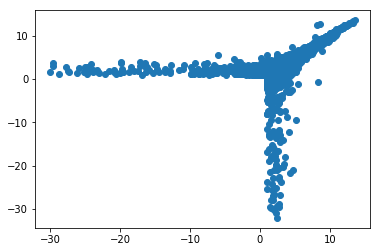

In [68]:
plt.scatter(np.log2(rpl22_oe_sleuth["control_median"]),np.log2(rpl22_oe_sleuth["treatment_median"]))

In [67]:
rpl22_oe_sleuth["control_median"] = rpl22_oe_sleuth[experiments["rpl22_oe"][0]].median(axis=1)
rpl22_oe_sleuth["treatment_median"] = rpl22_oe_sleuth[experiments["rpl22_oe"][1]].median(axis=1)
rpl22_oe_sleuth = rpl22_oe_sleuth[(rpl22_oe_sleuth["control_median"]>=1)|(rpl22_oe_sleuth["treatment_median"]>=1)]
rpl22_oe_sleuth["median_foldchange"] = rpl22_oe_sleuth["treatment_median"]/rpl22_oe_sleuth["control_median"]


# Differential splicing

In [26]:
rpl22_oe_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22_oe.txt",sep="\t")
rpl22l1_oe_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22l1_oe.txt",sep="\t")
sh704_rmats = pd.read_csv("../data/processed/rmats_merge/sh704.txt",sep="\t")
sh705_rmats = pd.read_csv("../data/processed/rmats_merge/sh705.txt",sep="\t")

In [27]:
def plot_psi_dist(exon_id, experiment_id, diff_results, ax=None, pal=None, xlabel=None, ylabel=None):

    if ax is None:
        ax = plt.subplot(111)

    if pal is None:
        pal = sns.color_palette([control_color, treatment_color])

    if xlabel is None:
        xlabel = experiment_id

    if ylabel is None:
        ylabel = "mRNA expression, log2(TPM + 1)"

    select_abundance = diff_results.loc[exon_id]

    controls = experiments[experiment_id][0]
    treatments = experiments[experiment_id][1]

    tpms = np.log2(select_abundance[controls+treatments].astype(np.float64)+1)

    expression_df = pd.DataFrame(index=controls+treatments)

    expression_df["tpm"] = tpms
    expression_df["treatment"] = ["control"] * \
        len(controls)+["treatment"]*len(treatments)

    sns.swarmplot(x="treatment",
                  y="tpm",
                  data=expression_df,
                  ax=ax,
                  palette=pal,
                  s=6,
                  alpha=alpha,
                  linewidth=1,
                  edgecolor="black",
                  )
    
    means = expression_df.groupby("treatment")["tpm"].mean()
    
    ax.axhline(means["control"], 0.15,0.35, linewidth=2, color="black", zorder=100)
    ax.axhline(means["treatment"], 0.65,0.85, linewidth=2, color="black", zorder=100)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    
    plt.ylim(0)
    
    y_max = max(tpms)
    
    if not np.isnan(select_abundance["qval"]):
    
        qval = as_si(select_abundance["qval"],0)
        ax.text(0.5, y_max*1.2, qval,ha="center",fontsize=8)

    return ax, y_max
